![image](https://raw.githubusercontent.com/seisbench/seisbench/main/docs/_static/seisbench_logo_subtitle_outlined.svg)

*This code is necessary on colab to install SeisBench. If SeisBench is already installed on your machine, you can skip this.*

In [ ]:
!pip install seisbench

*This cell is required to circumvent an issue with colab and obspy. For details, check this issue in the obspy documentation: https://github.com/obspy/obspy/issues/2547*

In [ ]:
try:
    import obspy
    obspy.read()
except TypeError:
    # Needs to restart the runtime once, because obspy only works properly after restart.
    print('Stopping RUNTIME. If you run this code for the first time, this is expected. Colaboratory will restart automatically. Please run again.')
    exit()

# Training SeisDAE model

This tutorial shows how to train a model with SeisBench, using SeisDAE as an example, and also how to set up a noise dataset that is required to train a denoising model. This tutorial has many lines of code in common with the tutorial how to train a PhaseNet model. However, training a denoising model requires different augmentation techniques.

*Note: As this tutorial brings together different parts of seisbench, it is recommended to go through the basic tutorials first before beginning this tutorial. In addition, this tutorial assumes some familiarity with pytorch*

In [1]:
import pathlib
import torch
import random

import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from scipy.signal import stft, istft

import seisbench.data as sbd
import seisbench.models as sbm
import seisbench.generate as sbg
import seisbench.util as sbu
from seisbench.util import worker_seeding

from obspy.clients.fdsn import Client
from obspy import UTCDateTime

## Model and Data
We create a model for SeisDAE using ```seisbench.models```and loading the earthquake and noise data which are required for taining. If a GPU is available, the model is moved on the GPU to speedup training. Since the short-time Fourier transform is required (STFT), parameters for ```nfft``` and ```nperseg``` (https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.stft.html) are required.
Two different examples are given to train a new denoiser model with SeisDAE and one the continue training of DeepDenoiser model. The examples have the following parameters:
1. `nsamples=6000`, `nfft=99`, `nperseg=60` (SeisDAE)
1. `nsamples=3000`, `nfft=60`, `nperseg=30` (SeisDAE)
1. `nsamples=3000`, `nfft=60`, `nperseg=30` (DeepDenoiser)

In [2]:
# Values for 60 s @ 100 Hz sampling rate (only model SeisDAE)
#<nsamples = 6000
#nfft = 99
#nperseg = 60

# Values for 30 s @ 100 Hz sampling rate (models SeisDAE and DeepDenoiser)
nsamples = 3000
nfft = 60
nperseg = 30

# Set up new model (SeisDAE) for training
# model = sbm.SeisDAE(sampling_rate=100,
#                     in_samples=nsamples,
#                     nfft=nfft,
#                     nperseg=nperseg)

# Load a pretrained SeisDAE model
model = sbm.SeisDAE.from_pretrained("stead_highsnr"))

# Set up model of DeepDenoiser to continue training of pretrained model
# model = sbm.DeepDenoiser.from_pretrained("original")

if torch.cuda.is_available():
    model.cuda()
    print("Running on GPU")
else:
    print("Running on CPU")

Running on CPU


/home/jheuel/nextcloud/code/seisbench/seisbench/models/base.py:877: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_weights = torch.load(f"{path_pt}", **kwargs)


### Creating a noise dataset
When creating a noise dataset, we only need waveforms that do not contain an earthquake, i.e. no P- and S-phase arrivals are detected in a time window. In the example below, a noise dataset is created by random selection of 50 three-component seismological data from the ETH-Client. Seismic traces between start- and endtime are randomly selected and if the original PhaseNet model does not find any Phase onset in the selected time window, the waveform is saved in the dataset.

In [4]:
# Creating a noise dataset from obspy client
client = Client("ETH")
starttime = UTCDateTime("20250101")         # Choose startttime for noise samples
endtime = UTCDateTime("20250131")           # Choose endtime for noise samples 
window_length = 60                          # Window length of noise samples in seconds
num_traces = 50                             # Number of noise traces in dataset  
noise_base_path = pathlib.Path("./noise")   # Select pathname for noise dataset    
phasenet_model = sbm.PhaseNet.from_pretrained("original")  # Choose PhaseNet model to find picks in waveforms

# Name metadata and waveforms files
metadata_path = noise_base_path / "metadata.csv"               
waveforms_path = noise_base_path / "waveforms.hdf5"

# Create dataset
with sbd.WaveformDataWriter(metadata_path, waveforms_path) as writer:
    writer.data_format = {
        "dimension_order": "CW",
        "component_order": "ZNE",
        "measurement": "velocity",
        "unit": "counts",
        "instrument_response": "not restituted",
    }

    diff_seconds = int(endtime - starttime)  # Seconds between start- and endtime to select random starttime
    trace_count = 0  # Counter for number of traces in dataset
    while trace_count < num_traces:  # Loop until certain number of traces is found
        trace_starttime = starttime + np.random.randint(0, diff_seconds)  # Select random start- and endtime for stream
        trace_endtime = trace_starttime + window_length
        stations = client.get_stations(starttime=trace_starttime,     # Get all available stations from client
                                       endtime=trace_endtime,
                                       channel="HH*")

        # Select random network and random station
        network = random.choice(stations.networks)
        station = random.choice(network.stations)

        # Get waveform data
        try:
            stream = client.get_waveforms(network=network.code,
                                          station=station.code,
                                          location="*",
                                          channel="HH*",
                                          starttime=trace_starttime,
                                          endtime=trace_endtime)
        except BaseException:
            continue

        # If stream does not have 3 traces continue with next randomly selected stream
        if len(stream) != 3:
            continue

        # Check for phase onsets in window using a PhaseNet model
        picks = phasenet_model.classify(stream).picks

        if len(picks) != 0:
            continue

        actual_t_start, data, _ = sbu.stream_to_array(
            stream,
            component_order=writer.data_format["component_order"],
        )

        # Write traces to noise dataset
        trace_params = {
            "station_network_code": network.code,
            "station_code": station.code,
            "trace_channel": stream[0].stats.channel[:2],
            "station_location_code": stream[0].stats.location,
            "trace_sampling_rate_hz": stream[0].stats.sampling_rate,
            "trace_start_time": str(actual_t_start),
            "trace_category": "noise",
        }

        writer.add_trace({**trace_params}, data)

        trace_count += 1

/home/jheuel/nextcloud/code/seisbench/seisbench/models/base.py:877: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_weights = torch.load(f"{path_pt}", **kwargs)
Traces c

### Loading datasets
After creating a noise dataset, the earthquake and noise datasets are loaded to start training of SeisDAE.

In [5]:
# Load earthquake dataset
earthquake_dataset = sbd.DummyDataset(sampling_rate=100,
                                      component_order="ZNE")

# Load noise dataset
noise_dataset = sbd.WaveformDataset(path=noise_base_path,
                                    sampling_rate=100,
                                    component_order="ZNE")

# Split earthquake dataset into training, validation and testing
eq_train, eq_val, eq_test = earthquake_dataset.train_dev_test()

## Generator pipeline
STEAD contains labels for P- and S-arrivals (e.g., trace_p_arrival_sample). These arrival types are mapped to P and S using a dictionary.

In [6]:
phase_dict = {
    "trace_p_arrival_sample": "P",
    "trace_s_arrival_sample": "S",
}

Now we define two generators with identical augmentations, one for training, one for validation. The augmentations are:
1. Selection of a (long) window around a pick. This way, we ensure that out data always contains a pick.
1. Selection of a random window with the length of ```nsamples```.
1. A labeller to produce the masking functions for earthquake, noise and noisy waveforms. The labeller also normalizes the traces and can work either with a single component, e.g. Z, or with several components, e.g. ZNE.
1. A change of datatype to float32, as this is expected by the pytorch model.

In [7]:
train_generator = sbg.GenericGenerator(eq_train)
val_generator = sbg.GenericGenerator(eq_val)

augmentations = [
    sbg.WindowAroundSample(list(phase_dict.keys()),
                           samples_before=int(0.8 * nsamples),
                           windowlen=int(1.5 * nsamples),
                           selection="first",
                           strategy="variable"),
    sbg.RandomWindow(windowlen=nsamples,
                     strategy="pad"),
    sbg.STFTDenoiserLabeller(noise_dataset=noise_dataset,
                         nfft=nfft,
                         nperseg=nperseg,
                         scaling_type="peak",
                         component="Z",
                         scale=(0, 5)),   # Adjust scaling for your dataset (Default is scale=(0, 1)
    sbg.ChangeDtype(np.float32),
]

train_generator.add_augmentations(augmentations=augmentations)
val_generator.add_augmentations(augmentations=augmentations)

Let's visualize a few training examples (real and imaginary part of noisy waveform (left) and mask functions for earthquake and noise (right)). Everytime you run the cell below, you'll see a different training example.

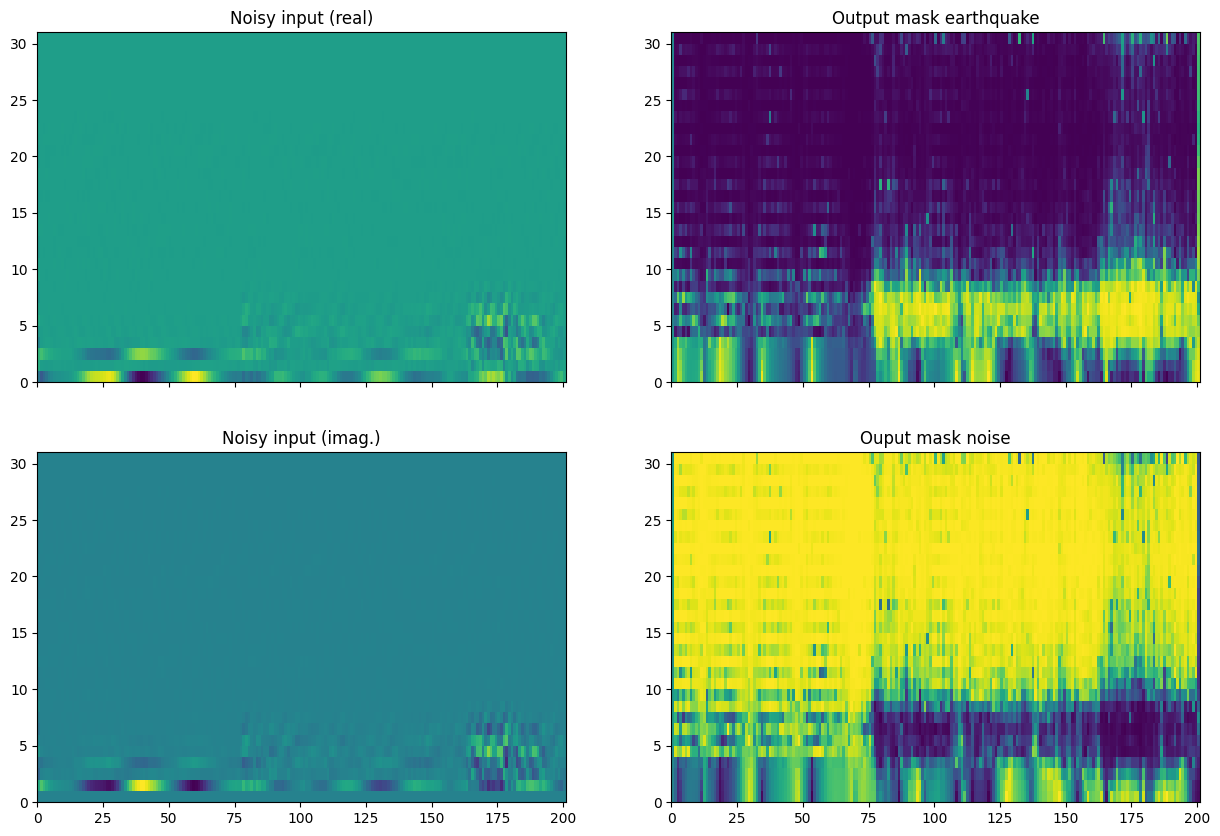

In [8]:
sample = train_generator[np.random.randint(len(train_generator))]

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 2, sharex=True)
# Input of CNN
axs[0, 0].pcolormesh(sample["X"][0, :])  # Noisy real
axs[1, 0].pcolormesh(sample["X"][1, :])  # Noisy imag
# Output of CNN
axs[0, 1].pcolormesh(sample["y"][0, :])  # mask earthquake
axs[1, 1].pcolormesh(sample["y"][1, :])  # mask noise

axs[0, 0].set_title("Noisy input (real)")
axs[1, 0].set_title("Noisy input (imag.)")
axs[0, 1].set_title("Output mask earthquake")
axs[1, 1].set_title("Ouput mask noise");

SeisBench generators are pytorch datasets. Therefore, we can pass them to pytorch data loaders. These will automatically take care of parallel loading and batching. Here we create one loader for training and one for validation. We choose a batch size of 128 samples. This batch size is rather small due to the size of the model (1.3 M parameters) However, this should fit on most hardware.
*For training models on GPUs with larger datasets, we recommend a larger batch size (e.g. 512 or 1024). 

In [9]:
batch_size = 128
num_workers = 8  # The number of threads used for loading data

train_loader = DataLoader(dataset=train_generator,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=num_workers,
                          worker_init_fn=worker_seeding)
val_loader = DataLoader(dataset=val_generator,
                        batch_size=batch_size,
                        num_workers=num_workers,
                        worker_init_fn=worker_seeding)

## Training a model
Now we got all components for training the model. What we still need to do is define the optimizer and the loss, and write the training and validation loops.

In [10]:
learning_rate = 1e-2
epochs = 1

optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate)
loss_fn = torch.nn.BCELoss()

In [11]:
def train_loop(dataloader):
    size = len(dataloader.dataset)
    for batch_id, batch in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(batch["X"].to(model.device))
        loss = loss_fn(input=pred.float(), 
                       target=batch["y"].to(model.device).float())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_id % 50 == 0:
            loss, current = loss.item(), batch_id * batch["X"].shape[0]
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader):
    num_batches = len(dataloader)
    test_loss = 0

    model.eval()  # close the model for evaluation

    with torch.no_grad():
        for batch in dataloader:
            pred = model(batch["X"].to(model.device))
            test_loss += loss_fn(input=pred.float(), 
                                 target=batch["y"].to(model.device).float())

    model.train()  # re-open model for training stage

    test_loss /= num_batches
    print(f"Test avg loss: {test_loss:>8f} \n")

In [ ]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader)
    test_loop(val_loader)

## Saving the model
In case you would like to save your model, run the following code:

In [ ]:
model.save(path="./my_seisdae_model")

Later, you can load the model by calling `sbm.SeisDAE.load("./my_seisdae_model")`

## Evaluating the model

Now we can evaluate the trained model. In the first part, the STFT and masling functions are displayed. First, we will check how the model does work on an example from the validation set. Note that the model will most likely not be fully trained after only five epochs.

-1.0 0.84482855
7.12207610314461e-07 0.9976313875792279


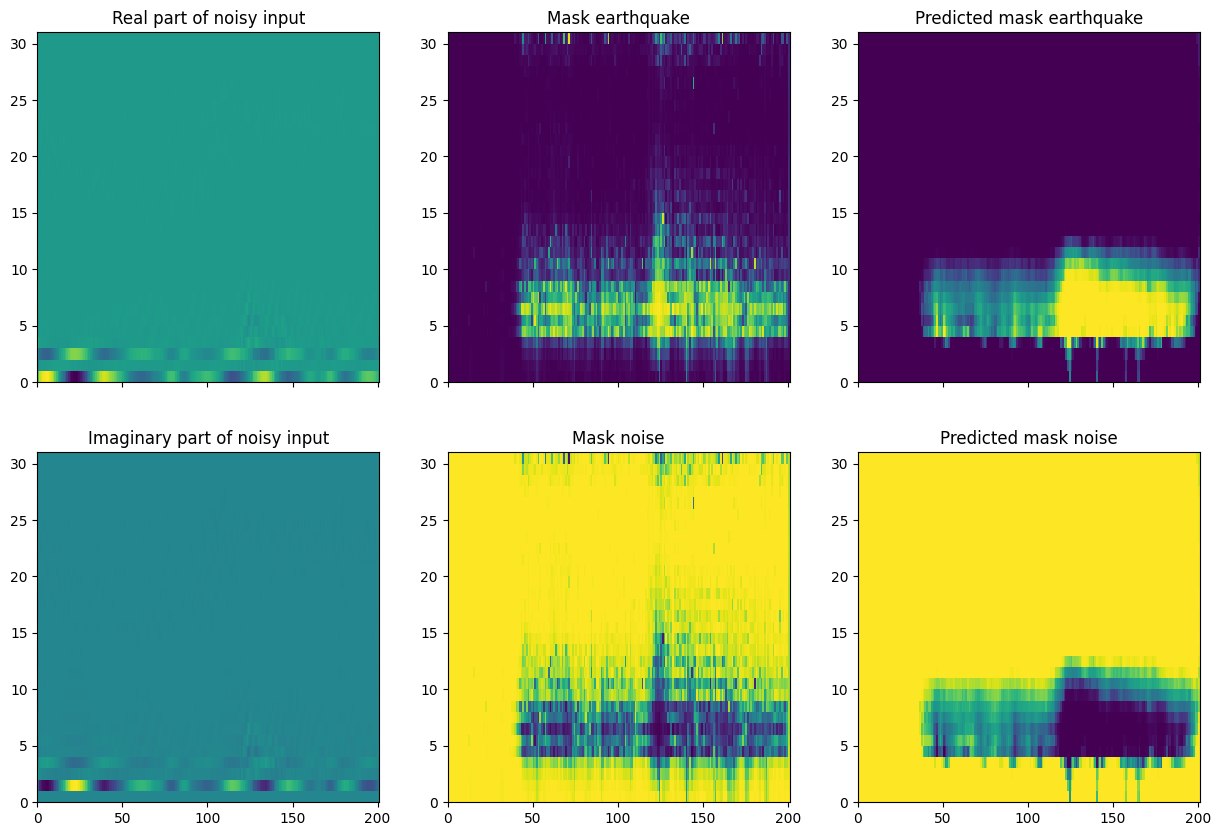

In [17]:
sample = val_generator[np.random.randint(len(val_generator))]
print(np.min(sample["X"][0, :]), np.max(sample["X"][0, :]))
print(np.min(sample["y"][0, :]), np.max(sample["y"][0, :]))
fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 3, sharex=True)
axs[0, 0].pcolormesh(sample["X"][0, :])  # Noisy input real
axs[1, 0].pcolormesh(sample["X"][1, :])  # Noisy input imag

axs[0, 1].pcolormesh(sample["y"][0, :])  # Mask earthquake
axs[1, 1].pcolormesh(sample["y"][1, :])  # Mask noise

model.eval()  # close the model for evaluation

with torch.no_grad():
    pred = model(torch.tensor(sample["X"], device=model.device).unsqueeze(0))  # Add a fake batch dimension
    pred = pred[0].cpu().numpy()

axs[0, 2].pcolormesh(pred[0, :]);  # Predicted mask earthquake
axs[1, 2].pcolormesh(pred[1, :]);  # Predicted mask noise

axs[0, 0].set_title("Real part of noisy input")
axs[1, 0].set_title("Imaginary part of noisy input")
axs[0, 1].set_title("Mask earthquake")
axs[1, 1].set_title("Mask noise")
axs[0, 2].set_title("Predicted mask earthquake")
axs[1, 2].set_title("Predicted mask noise");

Instead of plotting STFT and masking functions, we will plot waveforms of noisy earthquake waveform, earthquake without noise and predicted denoised waveform, using the inverse short-time Fourier transform (ISTFT, https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.istft.html).

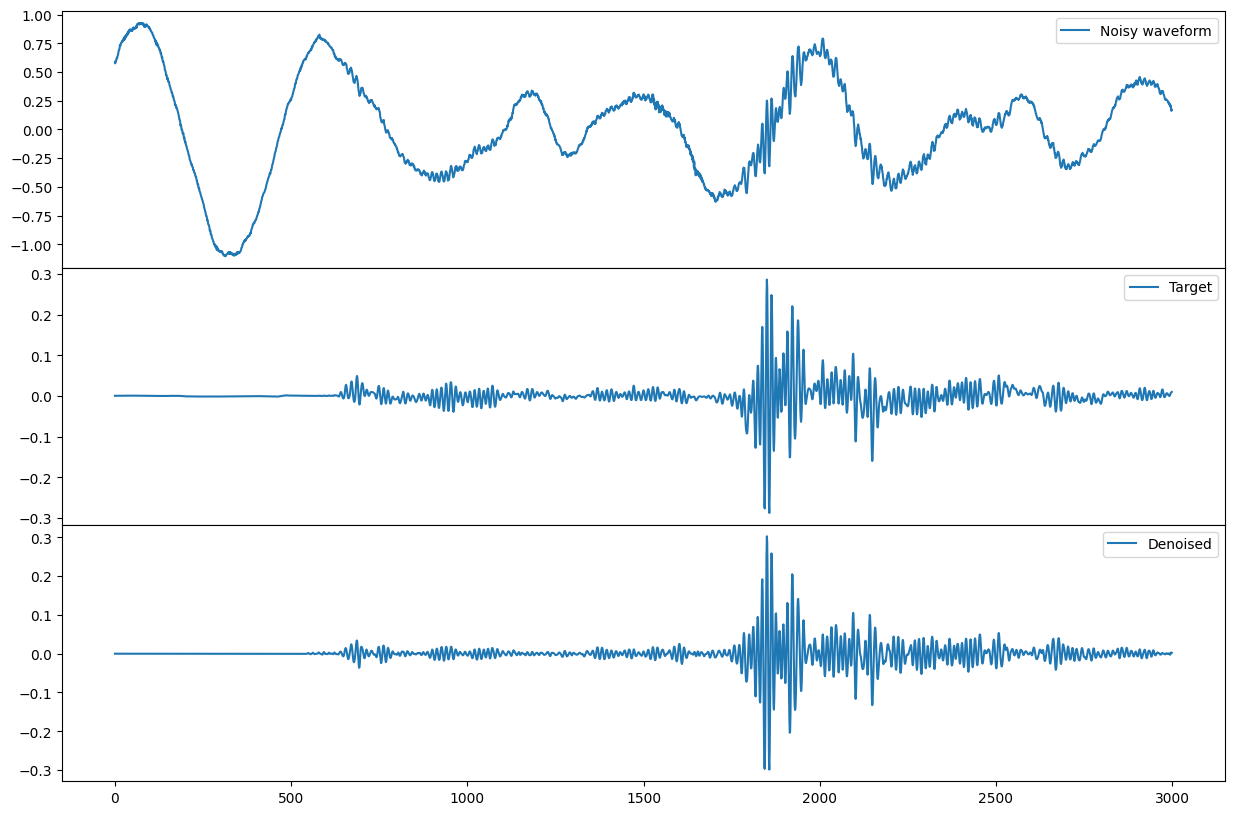

In [18]:
stft_noisy = sample["X"][0, :] + 1j * sample["X"][1, :]
stft_earthquake_target = stft_noisy * sample["y"][0, :]
stft_noise_target = stft_noisy * sample["y"][1, :]
stft_earthquake_prediction = stft_noisy * pred[0, :]
stft_noise_prediction = stft_noisy * pred[1, :]

# Transform back into time domain
_, noisy_waveform = istft(Zxx=stft_noisy,
                          fs=100,
                          nfft=nfft,
                          nperseg=nperseg)
_, target_earthquake = istft(Zxx=stft_earthquake_target,
                             fs=100,
                             nfft=nfft,
                             nperseg=nperseg)
_, prediction_earthquake = istft(Zxx=stft_earthquake_prediction,
                                 fs=100,
                                 nfft=nfft,
                                 nperseg=nperseg)

# Plot earthquake waveforms of noisy, target earthquake and predicted earthquake
fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(3, 1, gridspec_kw={"hspace": 0, "height_ratios": [1, 1, 1]})
axs[0].plot(noisy_waveform, label="Noisy waveform")
axs[1].plot(target_earthquake, label="Target")
axs[2].plot(prediction_earthquake, label="Denoised")
for ax in axs:
    ax.legend();

As a second option, we'll directly apply our model to an obspy waveform stream using the `annotate` function. For this, we are downloading waveforms through FDSN and annotating them. Note that you could use the `classify` function in a similar fashion.

/tmp/ipykernel_3373/2970122163.py:17: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  axs[0].plot_date(stream[0].times("matplotlib"), stream[0].data - np.mean(stream[0].data),
/tmp/ipykernel_3373/2970122163.py:19: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  axs[1].plot_date(denoised[0].times("matplotlib"), denoised[0].data,


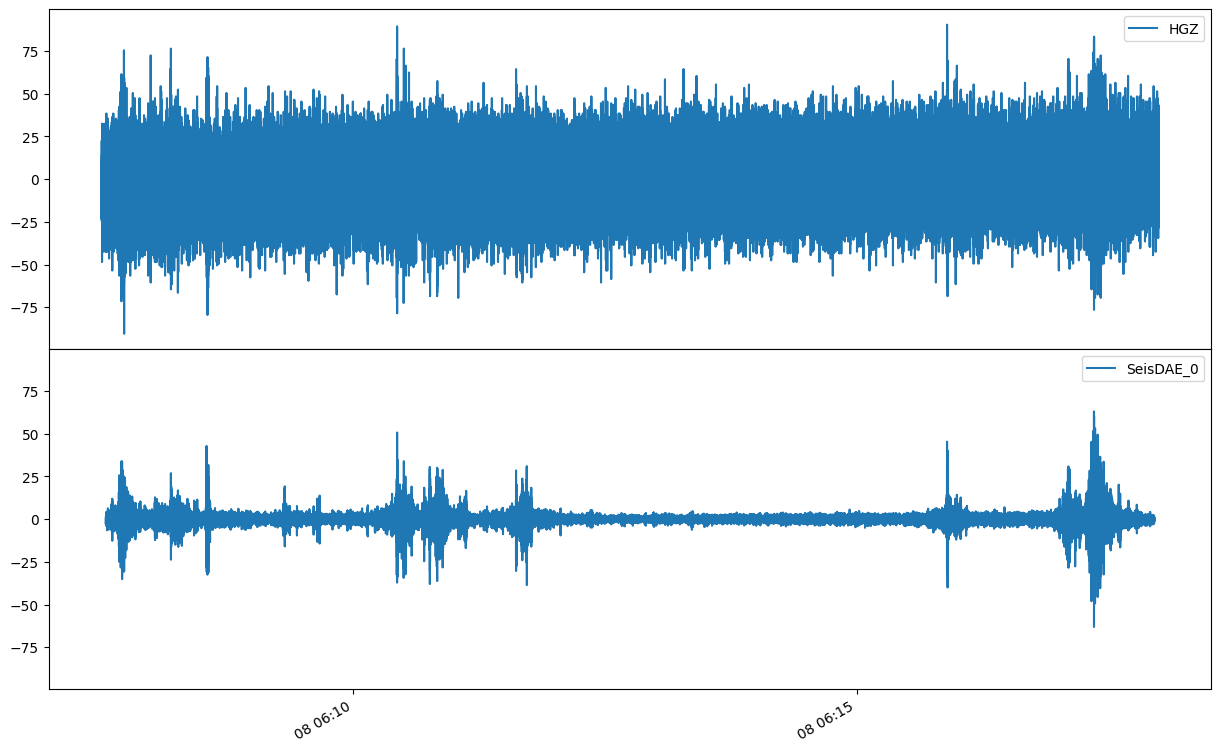

In [23]:
client = Client("ETH")

t = UTCDateTime("2025-06-08 06:08")
stream = client.get_waveforms(network="CH", 
                              station="SVBE", 
                              location="*", 
                              channel="HGZ", 
                              starttime=t-30, 
                              endtime=t+60*10)

denoised = model.annotate(stream,
                          blinding=[250, 250])

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharey=True, sharex=True, 
                   gridspec_kw={"hspace": 0, "height_ratios": [1, 1]})
axs[0].plot_date(stream[0].times("matplotlib"), stream[0].data - np.mean(stream[0].data),
                 label=stream[0].stats.channel, linestyle='solid', marker=None)
axs[1].plot_date(denoised[0].times("matplotlib"), denoised[0].data,
                 label=denoised[0].stats.channel, linestyle='solid', marker=None)

axs[0].legend()
axs[1].legend()
plt.gcf().autofmt_xdate()

## Remarks
1. In case you get the Error `ValueError: If data with length ... are transformed with STFT and back transformed with ISTFT, the output lenght of ISTFT (...) does not match. Choose different values for nfft=... and nperseg=....` choose different values for STFT and ISTFT. Below you find a function to test whether the length of the data transformed back to time domain match the the original data. If not you have to find other values by trial and error.
2. Since the approach assumes that the noisy signal is a superposition of noise and clean earthquake waveform, the amplitude of the denoised waveform is always smaller or equal to amplitude of the noisy waveform.
3. Creating noise datasets can be done more accurately, for example checking earthquake catalogues and remove time spans with earthquakes in that region.
4. The noise dataset in this example only has 50 traces. In pratice users shoould us much larger noise datasets.

In [ ]:
def stft_params(nfft: int,
                nperseg: int, 
                samples: int,
                sampling_rate: float = 100):
    """
    Testing whether STFT and ISTFT result in sample length of waveform data.
    """
    # Performing STFT
    _, _, dummystft = stft(
            x=np.random.rand(samples),
            fs=sampling_rate,
            nfft=nfft,
            nperseg=nperseg,
        )
    # Performing ISTFT
    t, dummy_x = istft(
        Zxx=dummystft,
        fs=sampling_rate,
        nfft=nfft,
        nperseg=nperseg,
    )

    if len(dummy_x) != samples:
    msg = (
        f"If data with length {samples} are transformed with STFT and back transformed with "
        f"ISTFT, the output lenght of ISTFT ({len(dummy_x)}) does not match. Choose different values "
        f"for nfft={nfft} and nperseg={nperseg}."
    )